In [2]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay, fowlkes_mallows_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime
import math

In [3]:
# Read in CSV Data
dataset = pd.read_csv('./data/creditcard.csv')
len(dataset.columns.drop('Class'))

30

In [6]:
"""
Utility functions for
1. Splitting data into training and test
2. Creating a Gaussian Mixture Model and Running the EM Algorithm
3. Performing K-Fold Cross Validation with 
"""
### Util functions to train models ###
def get_train_test_splits(X: np.ndarray, Y: np.ndarray, train_index: np.ndarray, test_index: np.ndarray) -> tuple:
    """
    Splits data and labels into train and test portions

    Args:
        X (np.ndarray): Normalized Data
        Y (np.ndarray): Labels
        train_index (np.ndarray): Indices corresponding to train data/labels from K-Fold
        test_index (np.ndarray): Indices corresponding to test data/labels from K-Fold

    Returns:
        tuple: Returns x_train, x_test, y_train, y_test
    """
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    return x_train, x_test, y_train, y_test

def get_trained_model(x_train: np.ndarray, num_iterations: int) -> GaussianMixture:
    """
    Creates a Gaussian Mixture Model and runs the EM Algorithm

    Args:
        x_train (np.ndarray): Training Data
        num_iterations (int): Number of times to run the EM Algorithm

    Returns:
        GaussianMixture: Trained Gaussian Mixture Model
    """
    gmm = GaussianMixture(n_components=2, n_init=num_iterations)
    return gmm.fit(x_train)

def get_model_predictions(model: GaussianMixture, x_test: np.ndarray, y_test: np.ndarray) -> tuple:
    """
    Classifies test data based on trained Gaussian Model

    Args:
        model (GaussianMixture): The Trained Gaussian Mixture Model
        x_test (np.ndarray): Testing data
        y_test (np.ndarray): Testing Labels (the ground truth)

    Returns:
        tuple: x_test, y_test, predictions
    """
    predictions = model.predict(x_test)
    return x_test, y_test, predictions

def train_and_test_model(unsupervised_data: np.ndarray) -> list:
    """
    Runs K-Fold Validation on the entire data, training and getting predictions for each fold

    Args:
        unsupervised_data (np.ndarray): Entire data from preprocessing

    Returns:
        list: List of (x_test, y_test, predictions) for displaying results later
    """
    K_FOLDS = 5
    NUM_ITERATIONS = 10

    results = []
    count = 0
    for train_index, test_index in KFold(shuffle=True, n_splits=K_FOLDS).split(unsupervised_data):
        count += 1
        print(f'Running fold # {count}')

        # Splitting data and obtaining trained model
        print("Splitting Data")
        x_train, x_test, _, y_test = get_train_test_splits(unsupervised_data, labels, train_index, test_index)
        
        # Training Model
        print("Training Model")
        model = get_trained_model(x_train, NUM_ITERATIONS)

        # Get Test Results for Models
        print("Testing and Obtaining Results")
        print()
        test_result = get_model_predictions(model, x_test, y_test)
        results.append(test_result)
    return results

In [7]:
''' 
Utility functions for 
1. Displaying Confusion Matrices
2. Calculating recall_rates
3. Calculating accuracies
4. Calculating Silhouette Scores
5. Calculating Fowlkes Mallows Scores
6. Displaying clusterings with respect to V1 and V2
'''
### Util functions for displaying results
def get_confusion_matrices(results: list) -> list:
    """
    Generates confusion matrices given results

    Args:
        results (list): A list of (x_test, y_test, predictions) tuples

    Returns:
        list: A list of confusion matrices, returns a list because there is a
              a confusion matrix for each for the folds in K-fold
    """
    matrices_of_confusion = []
    for i, (x_test, ground_truth, prediction) in enumerate(results):
        cm = confusion_matrix(ground_truth, prediction)
        if cm[0][0] < cm[0][1]:
            # This means the clusters were flipped (0 means fraud 1 means fraud)
            # so we switch our predictions
            results[i] = (x_test, ground_truth, 1 - prediction)
            cm = confusion_matrix(ground_truth, 1 - prediction)
        matrices_of_confusion.append(cm)
    return matrices_of_confusion

def get_recall_rates(matrices_of_confusion: list) -> list:
    """
    Calculates recall rates (percentage of frauds that were detected)

    Args:
        matrices_of_confusion (list): List of Confusion Matrices

    Returns:
        list: A list of recall rates, returns a list because there is a
              a recall rate for each for the folds in K-fold
    """
    recall_rates = []
    for confusion_matrix in matrices_of_confusion:
        recall = confusion_matrix[1][1] / (np.sum(confusion_matrix[1]))
        recall_rates.append(recall)
    return recall_rates

def get_accuracies(results: list) -> list:
    """
    Calculates accuracies (how well the model distinguishes fraud from not fraud)

    Args:
        results (list): A list of (x_test, y_test, predictions) tuples

    Returns:
        list: A list of accuracy rates, returns a list because there is a
              a recall rate for each for the folds in K-fold
    """
    accuracies = []
    for _, y_test, prediction in results:
        accuracy = np.count_nonzero(y_test == prediction) / len(y_test)
        accuracies.append(accuracy)
    return accuracies

def get_silhouette_scores(results: list) -> list:
    """
    Calculates silhouette_scores measured on a scale from -1 to 1
    (how well the clusters are distinguished and how far apart they are)

    Args:
        results (list): A list of (x_test, y_test, predictions) tuples

    Returns:
        list: A list of silhouette scores, returns a list because there is a
              a recall rate for each for the folds in K-fold
    """
    scores = []
    for x_test, _, prediction in results:
        score = silhouette_score(x_test, prediction)
        scores.append(score)
    return scores

def get_fowlkes_mallows_scores(results: list) -> list:
    """
    Calculates Fowlkes Mallows Scores (similarities between 2 clusters)
    https://scikit-learn.org/stable/modules/clustering.html#fowlkes-mallows-scores

    Args:
        results (list): A list of (x_test, y_test, predictions) tuples

    Returns:
        list: A list of Fowlkes Mallows Scores, returns a list because there is a
              a recall rate for each for the folds in K-fold
    """
    scores = []
    for _, ground_truth, prediction in results:
        score = fowlkes_mallows_score(ground_truth, prediction)
        scores.append(score)
    return scores

def plot_clusterings(results: list) -> None:
    """
    Plots Clustering with respect to V1 and V2 components

    Args:
        results (list): A list of (x_test, y_test, predictions) tuples
    """
    for count, (x_test, y_test, prediction_test) in enumerate(results):
        colors = {
            0: "green",
            1: "red"
        }
        for group in np.unique(y_test):
            indexes = np.where(group == prediction_test)
            plt.scatter(
                x_test[indexes, 1],
                x_test[indexes, 2],
                c=colors[group],
                s=5,
                label=group,
            )
        plt.title(f"Visualization of Clusterings using V1 and V2 for k={count + 1}")    
        plt.legend()
        plt.show()

In [42]:
"""
Main steps
1. Shuffle the dataset
2. Separate the labels from the data
3. Normalize the data via MinMaxScalar
4. Start from 2 columns and add components. For each component, run K-fold validation,
   keeping track of time taken to run for each component added
"""
# Shuffling the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Separating the labels from the data
labels = dataset['Class']
unsupervised_data = dataset.drop(columns=['Class'])

# Normalizing by Min/Max Scalar
unsupervised_data = MinMaxScaler(feature_range=(0, 1)).fit_transform(unsupervised_data)

times = []
col_iteration_results = []
for i in range(1, len(dataset.columns)):
    desired_columns = dataset.columns[:i]
    unsupervised_data = dataset[desired_columns]
    unsupervised_data = MinMaxScaler(feature_range=(0, 1)).fit_transform(unsupervised_data)
    start = datetime.now()
    print(f'RUNNING WITH {i} COLUMNS')
    print('---------------------------')
    results = train_and_test_model(unsupervised_data)
    end = datetime.now()
    col_iteration_results.append(results)
    times.append(math.ceil((end - start).total_seconds()))
    print()

Index(['Time'], dtype='object')
Index(['Time', 'V1'], dtype='object')
Index(['Time', 'V1', 'V2'], dtype='object')
Index(['Time', 'V1', 'V2', 'V3'], dtype='object')
Index(['Time', 'V1', 'V2', 'V3', 'V4'], dtype='object')
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5'], dtype='object')
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], dtype='object')
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7'], dtype='object')
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8'], dtype='object')
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9'], dtype='object')
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10'], dtype='object')
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11'],
      dtype='object')
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12'],
      dtype='object')
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       '

[array([0, 1]), array([2, 3])]

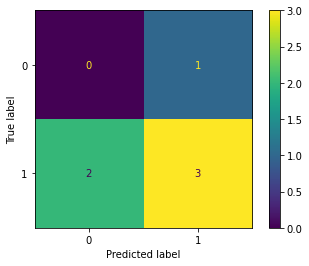

In [20]:
# Displaying Confusion Matrices for the iteration with all components
matrices_of_confusion = [get_confusion_matrices(result) for result in col_iteration_results]
for matrix in matrices_of_confusion[-1]:
    ConfusionMatrixDisplay(matrix).plot()

In [ ]:
# Display other metrics
accuracies, recalls, silhouette_scores, fowlkes_mallows_scores = [], [], [], []

for results in col_iteration_results:
    accuracies.append(np.mean(get_accuracies(results)))
    recalls.append(np.mean(get_recall_rates(get_confusion_matrices(results))))
    silhouette_scores.append(get_silhouette_scores([results[0]]))
    fowlkes_mallows_scores.append(np.mean(get_fowlkes_mallows_scores(results)))
num_components = np.arange(30)
print(f'Time taken: {times}')
print(f'Overall accuracies: {accuracies}')
print(f'Overall recall rates: {recalls}')
print(f'Silhouette Scores: {silhouette_scores}')
print(f'Fowlkes Mallows Scores: {fowlkes_mallows_scores}')
print(f'Confusion Matrices: {matrices_of_confusion}')

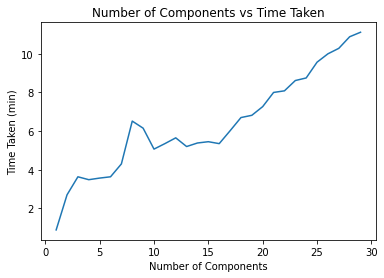

In [28]:
# Plotting the Number of Components vs Time Taken to run GMM
plt.plot(num_components, times / 60)
plt.title("Number of Components vs Time Taken")
plt.xlabel("Number of Components")
plt.ylabel("Time Taken (min)")
plt.show()

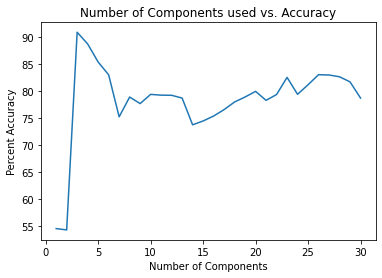

In [28]:
plt.plot(num_components, accuracies * 100)
plt.title("Number of Components used vs. Accuracy")
plt.xlabel("Number of Components")
plt.ylabel("Percent Accuracy")
plt.show()

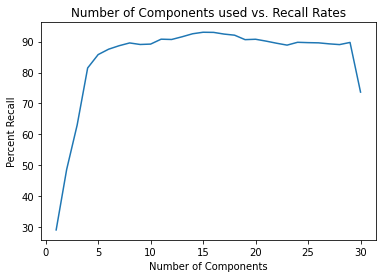

In [29]:
plt.plot(num_components, recall_rates * 100)
plt.title("Number of Components Used vs. Recall Rates")
plt.xlabel("Number of Components")
plt.ylabel("Percent Recall")
plt.show()

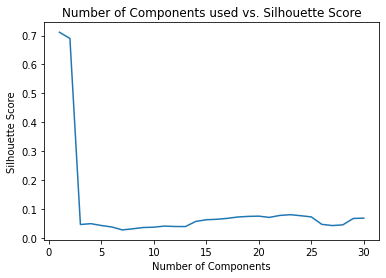

In [30]:
plt.plot(num_components, silhouette_scores)
plt.title("Number of Components used vs. Silhouette Score")
plt.xlabel("Number of Components")
plt.ylabel("Silhouette Score")
plt.show()

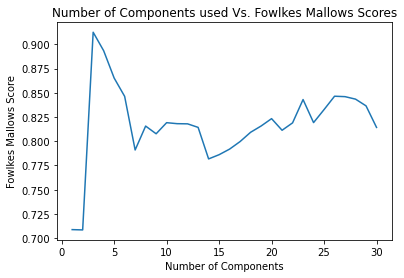

In [34]:
plt.plot(num_components, fowlkes_mallows_scores)
plt.title("Number of Components used Vs. Fowlkes Mallows Scores")
plt.xlabel("Number of Components")
plt.ylabel("Fowlkes Mallows Score")
plt.show()